표본의 각 사례마다 대응하는 2개의 관측치를 통해 판단
한 집단에 어떤 작용이 가해졌을 때에 대한 before, after를 비교


In [2]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from scipy.stats import t, normaltest, bartlett, levene, ttest_rel,mannwhitneyu
from statannotations.Annotator import Annotator

In [3]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)


# 예제 (1) - 사슴의 다리 길이 비교

In [4]:
origin = load_data("deer")
origin

[data] https://data.hossam.kr/data/lab10_/deer.xlsx
[desc] 사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata


,사슴,앞다리,뒷다리
0,1,138,142
1,2,136,140
2,3,147,144
3,4,139,144
4,5,143,142
5,6,141,146
6,7,143,149
7,8,145,150
8,9,136,142
9,10,146,148


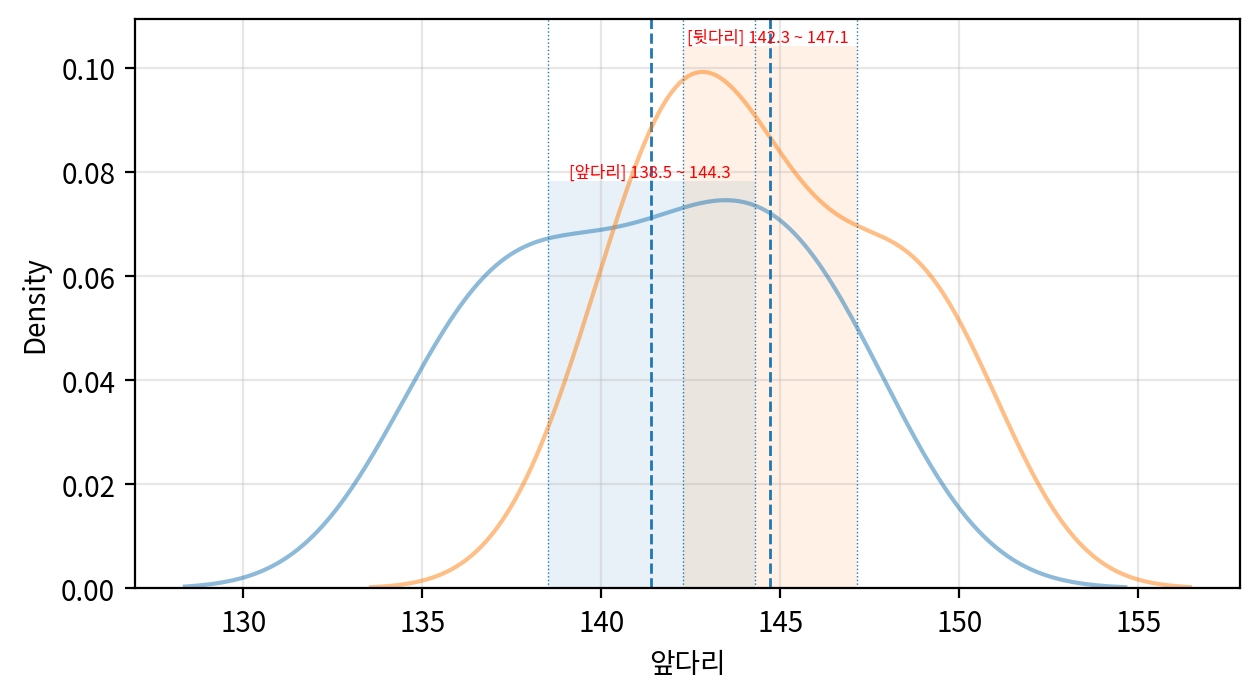

In [6]:
data = origin[['앞다리','뒷다리']]    #확인할 데이터

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c])-1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ax.text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (c, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})

ax.grid(True, alpha=0.3)

    
plt.tight_layout()
plt.show()
plt.close()

두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다.


In [ ]:
data = origin[['앞다리','뒷다리']]

equal_var_fields=[]
normal_dist = True
report = []

for c in data.columns:
    s, p =normaltest(data[c])

    normalize = p>0.05
    report.append({
        "field":c,
        "statistic":s,
        "p-value" : p,
        "result":normalize
    })
    normal_dist = normal_dist and normalize
#변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"
        #정규성을 충족할 경우의 검정방법
        s,p = bartlett(*data.values.T)
        #모든 컬럼의 데이터를 한번에 전달

    else:
        n = "Levene"    #정규성을 충족하지 않을 경우의 검정방법

        s, p = levene(*data.values.T, center='median')  # 모든 컬럼의 데이터를 한번에 전달

    report.append({
        "field":n,
        "statistic":s,
        "p-value" : p,
        "result":p>0.05
    })

report_df = DataFrame(report).set_index('field')
report_df






,statistic,p-value,result
field,,,
앞다리,1.824001,0.401720,True
뒷다리,1.376960,0.502339,True
Bartlett,0.340678,0.559438,True


In [ ]:
s, p =ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='two-sided')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.008, 대립가설 채택'

차이값에 대한 t통계량의 값이 -3.414이고 이에 대응되는 유의확률이 0.008이므로(p<=0.05)귀무가설을 기각하고 대립가설을 채택한다.

즉,사슴의 앞다리와 뒷다리의 길이에는 차이가 있다고 결론을 내릴 수 있다.

In [ ]:
s, p =ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.996, 귀무가설 채택'

차이값에 대한 t통계량의 값이 -3.414이고 이에 대응되는 유의확률이 0.996이므로(p>0.05)귀무가설을 기각할 수 없다.

즉, 앞다리는 뒷다리보다 길지 않다고 결론 내릴 수 있다.

In [ ]:
s, p =ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.004, 대립가설 채택'

차이값에 대한 t 통계량의 값이 -3.414이고, 이에 대응되는 유의 확률이 0.004이므로 (p<=0.05)귀무가설을 기각하고 대립가설을 채택한다.
즉, 사슴의 앞다리는 사슴의 뒷다리보다 짧다고 할 수 있다.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


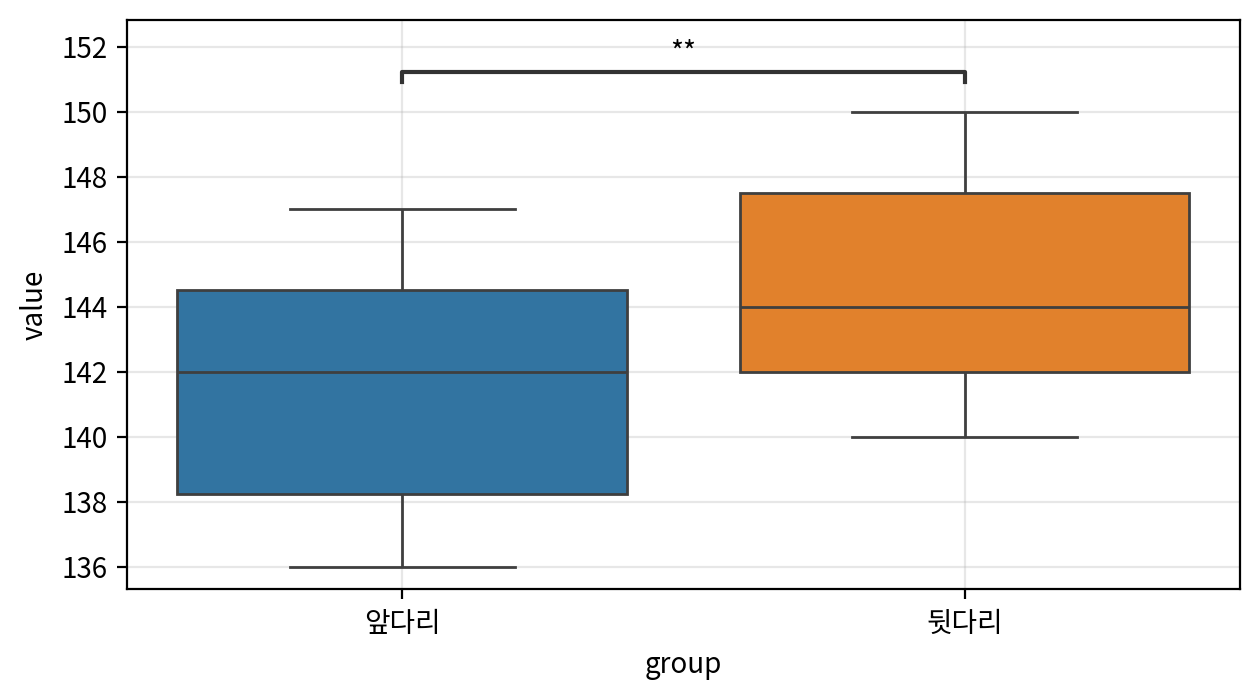

In [ ]:
#검정할 데이터 필드명
fields = ['앞다리', '뒷다리']

test_method = 't-test_paired'
df = melt(origin[fields], value_vars=fields, var_name='group',value_name='value')
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.boxplot(data=df, x='group',y='value',hue='group')

annotator = Annotator(ax, data=df, x='group', y='value', pairs=[fields])
annotator.configure(test=test_method)
annotator.apply_and_annotate()

ax.grid(True,alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()

# 예제(2)-자동차 첨가제가 주행거리에 미치는 영향

그룹A:첨가제를 사용한 경우, 그룹B: 첨가제를 사용하지 않은 경우

In [ ]:
origin = load_data("oil")
origin

[data] https://data.hossam.kr/data/lab10_/oil.xlsx
[desc] 다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 후 주행거리를 측정한 결과 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata


,그룹A,그룹B
0,13.2,11.8
1,13.1,13.9
2,16.3,12.1
3,14.9,10.5
4,14.2,9.3
5,16.1,16.3
6,15.1,15.1
7,13.6,12.3
8,15.8,11.6
9,14.2,8.4


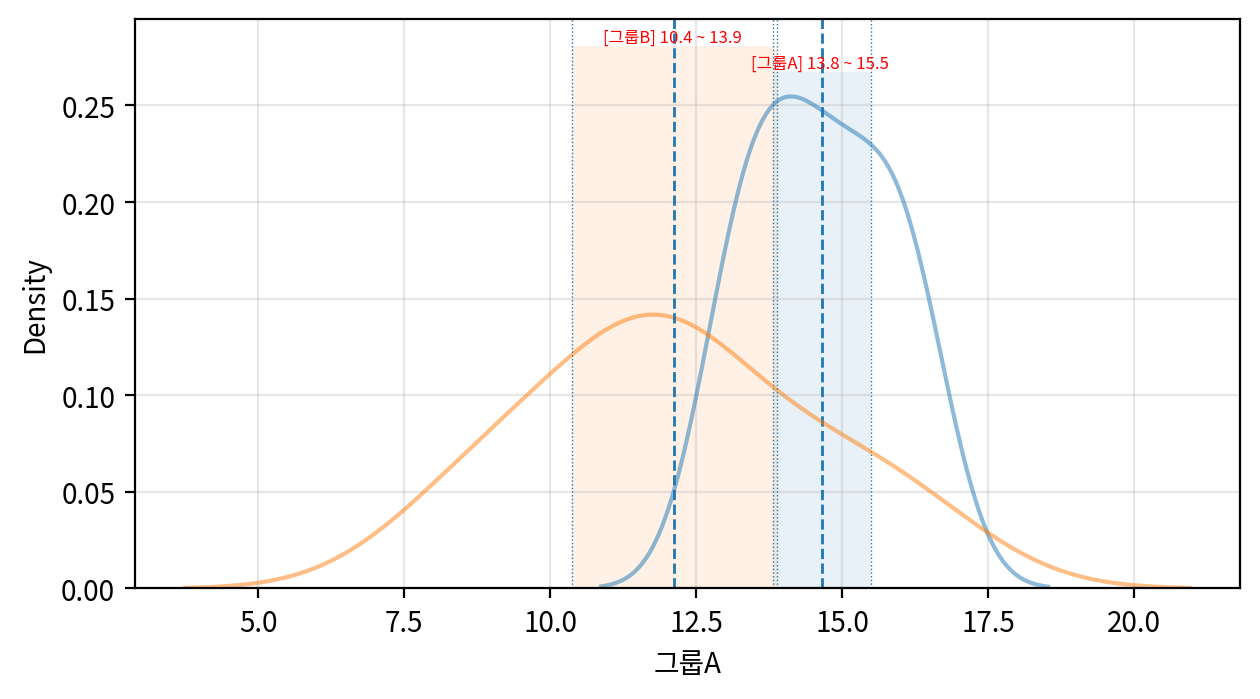

In [ ]:
data = origin[['그룹A','그룹B']] #확인할 데이터

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c])-1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ax.text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (c, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다.


In [ ]:
data = origin[['그룹A','그룹B']]

equal_var_fields=[]
normal_dist = True
report = []

for c in data.columns:
    s, p =normaltest(data[c])

    normalize = p>0.05
    report.append({
        "field":c,
        "statistic":s,
        "p-value" : p,
        "result":normalize
    })
    normal_dist = normal_dist and normalize
#변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"
        #정규성을 충족할 경우의 검정방법
        s,p = bartlett(*data.values.T)
        #모든 컬럼의 데이터를 한번에 전달

    else:
        n = "Levene"    #정규성을 충족하지 않을 경우의 검정방법

        s, p = levene(*data.values.T, center='median')  # 모든 컬럼의 데이터를 한번에 전달

    report.append({
        "field":n,
        "statistic":s,
        "p-value" : p,
        "result":p>0.05
    })

report_df = DataFrame(report).set_index('field')
report_df






,statistic,p-value,result
field,,,
그룹A,1.803522,0.405854,True
그룹B,0.151115,0.927227,True
Bartlett,4.272571,0.038732,False


데이터가 정규성을 만족하지만 등분산성은 만족하지 않는다.

In [ ]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative='two-sided')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.021, 대립가설 채택'

대응표본 검정결과에서 p값이 0.01로 유의수준 0.05보다 작으므로 차이가 없다는 귀무가설을 기각하고 대립가설을 채택한다.

따라서 첨가제를 사용하는 경우 주행거리에 차이가 있다고 판단된다.

In [ ]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.991, 귀무가설 채택'

대응표본 검정결과에서 p값이 0.991로 유의수준 0.05보다 작으므로 첨가제를 넣은 그룹의 주행거리가 첨가제를 넣지 않은 그룹의 주행거리보다 길지 않다는 귀무가설을 기각하고 대립가설을 채택한다.

즉, 첨가제를 넣은 A그룹의 주행거리가 더 길기 때문에 실험에 사용된 첨가제는 주행거리의 연장에 효과가 있다고 볼 수 잇다.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test greater, P_val:1.049e-02 U_stat=8.100e+01


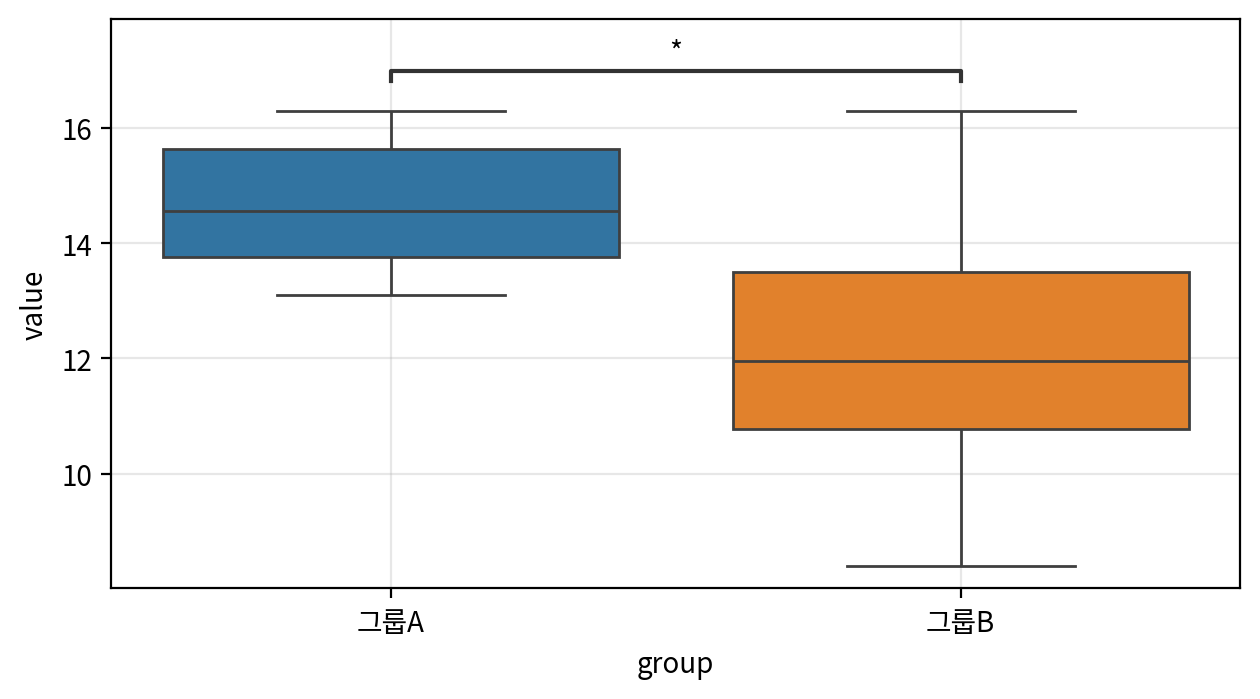

In [ ]:
fields = ['그룹A', '그룹B']

test_method = 'Mann-Whitney-gt'

df = melt(origin[fields], value_vars=fields, var_name='group', value_name='value')

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.boxplot(data=df, x='group',y='value',hue='group')
annotator = Annotator(ax, data=df, x='group', y='value', pairs=[fields])
annotator.configure(test=test_method)
annotator.apply_and_annotate()

ax.grid(True,alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()